In [2]:
%matplotlib inline
import math
import torch

from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size = 32
num_steps = 35


# train_iter 每次迭代器读取一个小批量
# vocab 字典 一个word和其对应的index相互转换
train_iter, vocab = d2l.load_data_time_machine(
    batch_size,
    num_steps
)

将之前读取到的文本对应的 word-index 字典转换成one_hot向量

In [3]:
# 长度为28 (26英文 + 一个空格 + 一个uniquetoken)
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

小批量数据形状 (批量大小[一批多少个]，时间步数[每次需要预测的长度]) 

In [4]:
X = torch.arange(10).reshape((2, 5))

# 转置的目的 将每批取出的数据放在连续空间
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

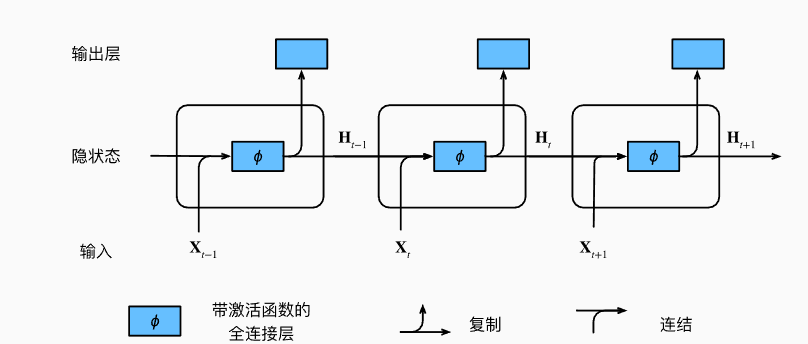

In [1]:
from IPython.display import Image
Image(filename = 'E:\Clancy\Code\动手学深度学习NLP篇\\RNN.png', width=10, height=10)

初始化循环神经网络的模型参数

In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size = shape, device = device) * 0.01

    # Hn = F(W_hh * Hn-1 + W_xh * Xn + b_h)

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # 增加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

一个 init_rnn_state 函数初始化时返回隐藏状态

In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [7]:
def rnn(inputs, state, params):

    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []

    # X的形状：(批量大小，词表大小)
    for X in inputs:
        
        # 体现出->该层的RNN共用一套模型参数
        H = torch.tanh(
            torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h
            )

        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)

    return torch.cat(outputs, dim=0), (H,)

创建一个类来包装函数

In [8]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""   
    def __init__(self, vocab_size, num_hiddens, device, 
                get_params, init_state, forward_fn):
        
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state = init_state
        self.forward_fn = forward_fn 
    
    # 此时的X是(批量大小，时间步数)
    def __call__(self, X, state):

        # 将X的规模变为 X ==> [时间步数, 批量大小, 特征向量长度]
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)

        # 投入forward_fn 可以得到输出state与更新后的参数params
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

检查输入是否具有正常结果

In [9]:
num_hiddens = 512

net = RNNModelScratch(
    len(vocab),num_hiddens,d2l.try_gpu(),
    get_params = get_params,
    init_state = init_rnn_state,
    forward_fn = rnn
)

# 测试案例 X 的批量大小是2 步长是5 一共10个数据
state = net.begin_state(X.shape[0], d2l.try_gpu())

Y, new_state = net(X.to(d2l.try_gpu()), state)

Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [2]:
# 对测试结果的输出进行解释

# Y.shape = (torch.Size([10, 28])
# ->
#     Y作为X[2,5]的预测值,X包含2组每组5个,一共10条数据,对应的输出也应该是10条
#     28 就是预测解雇word对应于index的one-hot

# len(new_state) = 1
# new_state[0].shape = torch.Size([2, 512])
# ->
#     新状态的参数 Size就是[批量大小, 隐藏层大小]

首先定义预测函数来生成 prefix 之后的新字符

In [12]:
# prefix : 即将要预测的句子的开头 
# num_preds : 预测的字符数
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix之后生成新的字符"""
    #初始化状态
    state = net.begin_state(batch_size = 1, device = device)

    # 将prefix 用vocab映射成index 放入 outputs中
    outputs = [vocab[prefix[0]]]

    # output[-1]:将上一层的最新的输出作为新的输入，转换成tensor形式
    get_input = lambda: torch.tensor([outputs[-1]],device=device).reshape((1,1))

    # 预测预热期
    for y in prefix[1:]:
        # 此时不需要输出的原因：在句子开始我们已经有了标准答案不需要预测值
        # 目的是为了初始化状态
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        # 只需取出最大一个分类 转换成标量 并且 转换成整型 保存到output里面
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# 测试案例
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller nbhqvokony'

梯度裁剪
$$\mathbf{g} \leftarrow \min\left(1, \frac{ \theta}
{\|\mathbf{g}\|}\right) \mathbf{g}$$

In [13]:
def grad_clipping(net, theta):

    if isinstance(net, nn.Module):
        # 取出所有有梯度的模型参数 (注意是所有不是某一层)
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params

    # 并且将所有的层与每一层的所有参数 拉成一条直线后，求梯度平方开根号 (L2范式)
    norm = torch.sqrt(sum(torch.sum(p.grad**2) for p in params))

    # 我们知道梯度范数永远不会超过theta,并且更新后的梯度完全与的原始方向对齐。
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

定义一个函数在迭代周期内的训练模型

In [14]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""

    # 初始化状态state与计时器timer
    state, timer = None, d2l.Timer()
    # 存储训练损失之和,词元数量
    metric = d2l.Accumulator(2)  

    for X, Y in train_iter:

        # use_random_iter : 上一个squence和这一个squence是否连续/相关
        # 如果是 则每一个采样都需要一次初始化
        # 否则 只需要在epoch开始时进行一次初始化
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
            
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        
        # y拉伸成一个向量
        y = Y.T.reshape(-1)

        # 训练
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()

        # 标准多分类训练方法
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    # CrossEntropy
    # metric[0] loss的累加 metric[1] 样本数
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经网络模型的训练函数既支持从零开始实现， 也可以使用高级API来实现

In [15]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, 
                use_random_iter = False):
    """训练模型"""
    # 虽然是语言模型 其实是标准多分类模型
    loss = nn.CrossEntropyLoss()

    animator = d2l.Animator(xlabel='epoch',
                            ylabel='perplexity',
                            legend=['train'],
                            xlim=[10,num_epochs])
    
    # 根据模型的写法选择优化器optimal
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(),lr)
    else:
        updater = lambda batch_size:d2l.sgd(net.params, lr, batch_size)

    # 包装之前的predict_ch8函数
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)

    # epoch训练
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)

        # 每十次输出一次预测
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller '))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))
            

困惑度 1.0, 87884.4 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


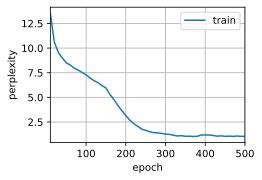

In [16]:
num_epoch, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epoch, d2l.try_gpu())

困惑度 1.3, 83184.8 词元/秒 cuda:0
time travellerit s against reason said filbywhat by modelsof thr
travellerit s against reason said filbywhat by modelsof thr


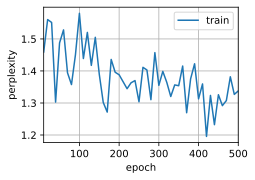

In [18]:
num_epoch, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epoch, d2l.try_gpu(), use_random_iter=True)